# Kakao talk 대화 분석

이 프로젝트는 단톡방에서 혼자 외롭게 소리없는 아우성을 지르는 저를 정성적으로 나타내어 보고 친구들에게 매마른 감정을 돌아보게 하는 목표를 가지고 있습니다.

In [91]:
text_file = open('KakaoTalk_20150823_2347_04_589_group.txt', 'r', encoding="utf8")

lines = text_file.readlines()   

In [100]:
# coding: utf-8
import re
import datetime
from datetime import date
import time
import numpy as np
from pandas import *
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")
rcParams['font.family'] = 'NanumGothic'
rcParams.update({'font.size': 12})

In [97]:
date_pattern = re.compile("-{15} (\d+)년 (\d+)월 (\d+)일 ([월, 화, 수, 목, 금, 토, 일]+)요일 -{15}")
message_pattern = re.compile("\[(\w+)\] \[([오후, 오전]+ \d+:\d+)\] (\w+)")
messages = []
date_now = date.today()
for idx, line in enumerate(lines):    
    date_match = date_pattern.match(line)
    message_match = message_pattern.match(line)
    if date_match:
        date_now = date(int(date_match.group(1)), int(date_match.group(2)), int(date_match.group(3)))                        
    elif message_match:         
        name = message_match.group(1)
        send_time = message_match.group(2)
        content = message_match.group(3)
        
        send_time = datetime.strptime(send_time.replace('오후','pm').replace('오전','am'), '%p %I:%M').time()        
        send_datetime = datetime.combine(date_now, send_time)
        message_item = {'name':name, 'date':date_now, 'timestamp':send_datetime, 'content':content} # type 추가 예정
        messages.append(message_item)                
        
        

In [98]:
df = DataFrame(messages)
df['hour'] = df['timestamp'].apply( lambda x : x.hour+ x.minute/60)

C:\Python34\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


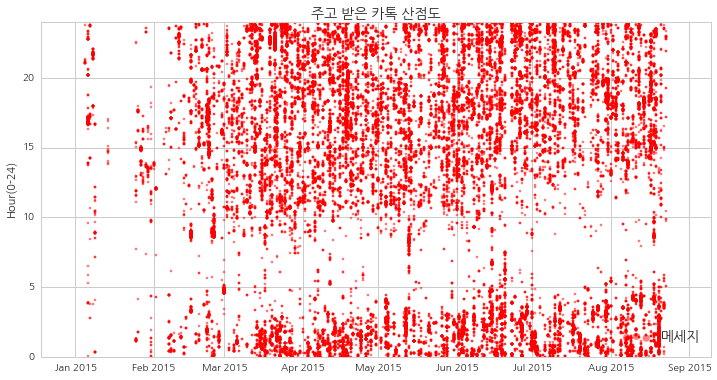

In [101]:
plt.figure(figsize=(12,6))
plt.scatter(df.date.tolist(), df.hour.tolist(), s=5, alpha=0.5, color='r', label='메세지')
plt.ylim(0,24)
plt.ylabel('Hour(0-24)')
plt.title("주고 받은 카톡 산점도",fontsize=14)
plt.legend(scatterpoints=3,
           loc='lower right',
           ncol=3,
           fontsize=14, markerscale = 3) 
plt.show()